In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import random
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt

df = pd.read_csv("../data/raw/Border_Crossing_Entry_Data.csv")
print "data loaded"
print df.head()

def agg_monthly_value(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by=['Date']).dropna()
    df = df.set_index('Date')
    data = df.groupby(['Date']).Value.sum()
    return data

data loaded
       Port Name       State  Port Code            Border  \
0  Calexico East  California       2507  US-Mexico Border   
1      Van Buren       Maine        108  US-Canada Border   
2      Otay Mesa  California       2506  US-Mexico Border   
3        Nogales     Arizona       2604  US-Mexico Border   
4    Trout River    New York        715  US-Canada Border   

                     Date                      Measure  Value  \
0  03/01/2019 12:00:00 AM                       Trucks  34447   
1  03/01/2019 12:00:00 AM         Rail Containers Full    428   
2  03/01/2019 12:00:00 AM                       Trucks  81217   
3  03/01/2019 12:00:00 AM                       Trains     62   
4  03/01/2019 12:00:00 AM  Personal Vehicle Passengers  16377   

                                Location  
0   POINT (-115.48433000000001 32.67524)  
1             POINT (-67.94271 47.16207)  
2            POINT (-117.05333 32.57333)  
3  POINT (-110.93361 31.340279999999996)  
4   POINT (-73.

Decomposition


<Figure size 1200x500 with 0 Axes>

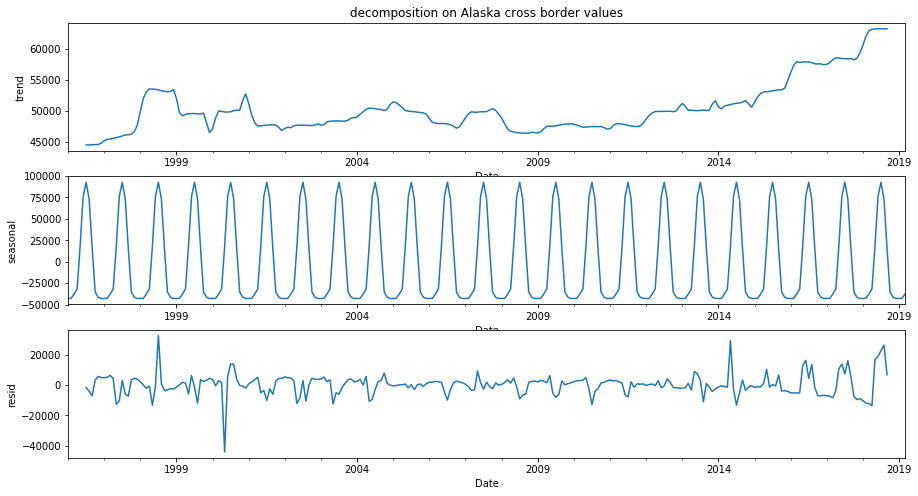

<Figure size 1200x500 with 0 Axes>

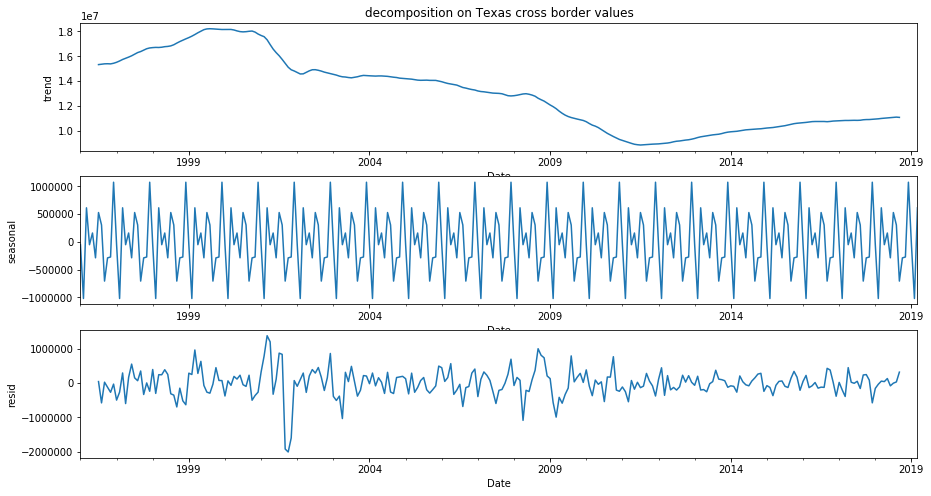

In [79]:
print "Decomposition"
def decompose_df(df, title, need_agg=False):
    if need_agg is True:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values(by=['Date']).dropna()
        df = df.set_index('Date')
        df = df.groupby(['Date']).Value.sum()
    plt.figure(figsize=(12, 5), dpi=100)
    decomposed = seasonal_decompose(df, model='additive')
    fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
    decomposed.trend.plot(ax=ax1)
    ax1.set_ylabel('trend')
    ax1.set_title("decomposition on {} cross border values".format(title))
    decomposed.seasonal.plot(ax=ax2)
    ax2.set_ylabel('seasonal')
    decomposed.resid.plot(ax=ax3)
    ax3.set_ylabel('resid')
    plt.show()
    
df_partial = df[(df['State'] == 'Alaska')]
data = agg_monthly_value(df_partial)
decompose_df(data, 'Alaska')

df_partial = df[(df['State'] == 'Texas')]
data = agg_monthly_value(df_partial)
decompose_df(data, 'Texas')

<Figure size 1200x500 with 0 Axes>

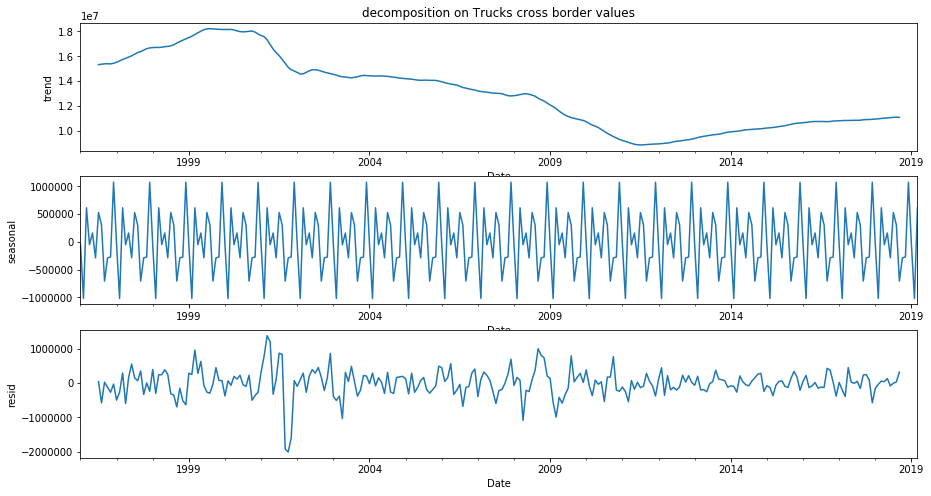

<Figure size 1200x500 with 0 Axes>

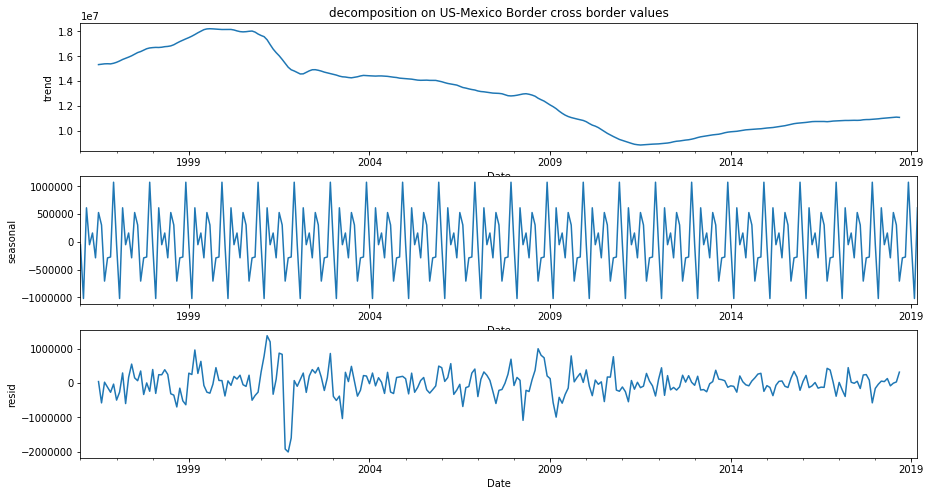

In [78]:
df_partial = df[(df['Measure'] == 'Trucks')]
data = agg_monthly_value(df_partial)
decompose_df(data_texas, 'Trucks')

df_partial = df[(df['Border'] == 'US-Mexico Border')]
data = agg_monthly_value(df_partial)
decompose_df(data_texas, 'US-Mexico Border')

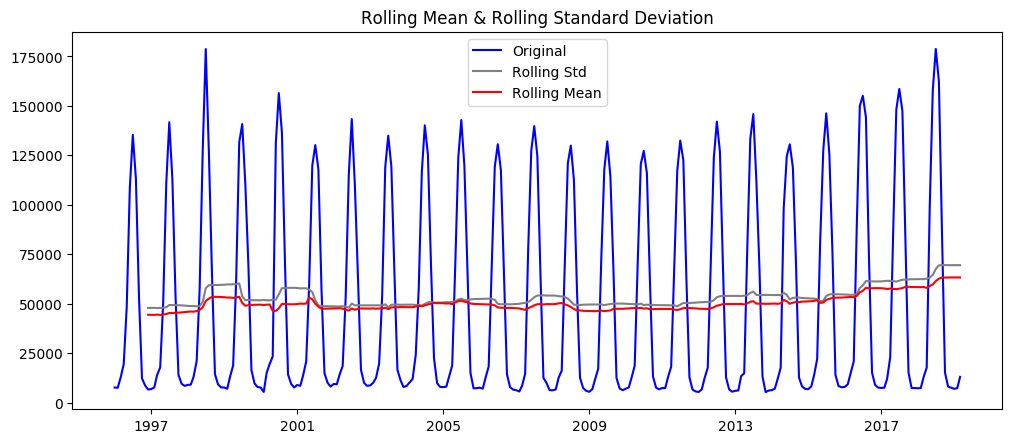

In [118]:
df_alaska = df[(df['State'] == 'Alaska')]
def plot_rolling_mean_std(df):
    data = agg_monthly_value(df)
    rolling_mean = data.rolling(window=12).mean()
    rolling_std = data.rolling(window=12).std()
    
    plt.figure(figsize=(12, 5), dpi=100)
    plt.plot(data, color='blue', label='Original')
    plt.plot(rolling_std, color ='grey', label='Rolling Std')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.show()
plot_rolling_mean_std(df_alaska)

In [91]:
def adfuller_test(df):
    print "Use Augmented Dickey-Fuller Test to see if time seies is stationary"
    adf_result = adfuller(df['Value'])
    print('ADF Statistic: %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])
adfuller_test(df_alaska)
print "p-value is less than 0.05, thus the time series is stationary"

Use Augmented Dickey-Fuller Test to see if time seies is stationary
ADF Statistic: -7.952436
p-value: 0.000000
p-value is less than 0.05, thus the time series is stationary


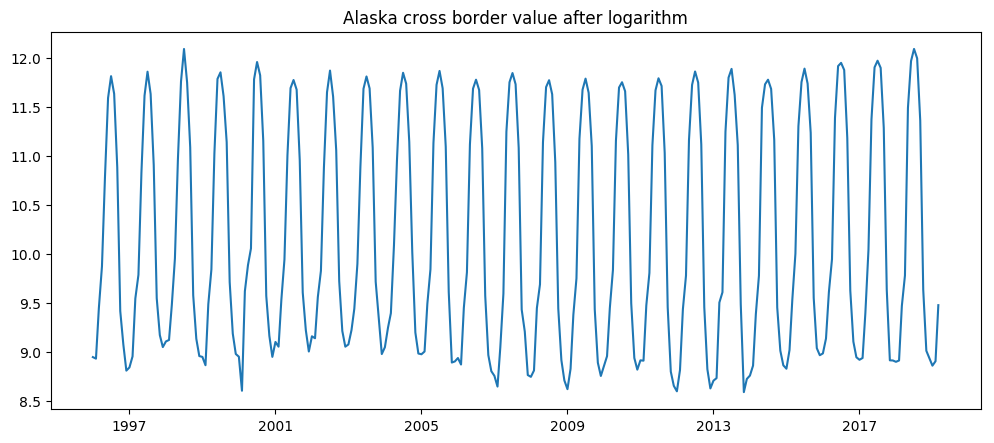

In [127]:
def log_df(df):
    data_agg = agg_monthly_value(df)
    df_log_r = np.log(data_agg)
    df_log_r.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_log_r.dropna(how="all", inplace=True)
    return df_log_r
df_log = log_df(df_alaska)
plt.figure(figsize=(12, 5), dpi=100)
plt.title('Alaska cross border value after logarithm')
plt.plot(df_log)

Use autocorrelation and partial autocorrelation for determining order of AR and MA model


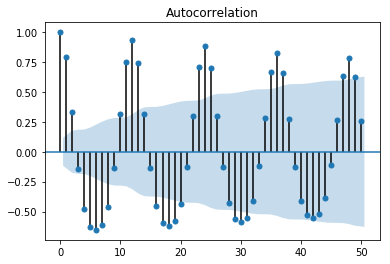

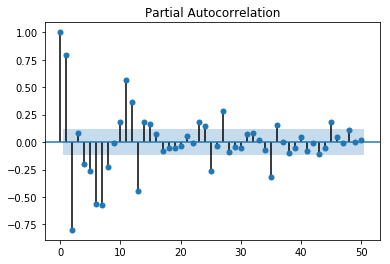

set p to 1 and q to 1


In [93]:
def plot_acf_pacf(df):
    data = agg_monthly_value(df)
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    print "Use autocorrelation and partial autocorrelation for determining order of AR and MA model"
    plot_acf(data, lags=50)
    plot_pacf(data, lags=50)
    plt.show()
plot_acf_pacf(df_alaska)
print "set p to 1 and q to 1"

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Value   No. Observations:                  237
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 107.028
Date:                            Tue, 03 Dec 2019   AIC                           -204.056
Time:                                    18:23:17   BIC                           -186.715
Sample:                                01-01-1996   HQIC                          -197.066
                                     - 09-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9966      0.005    195.886      0.000       0.987       1.007
ma.L1         -0.8965      0.026   

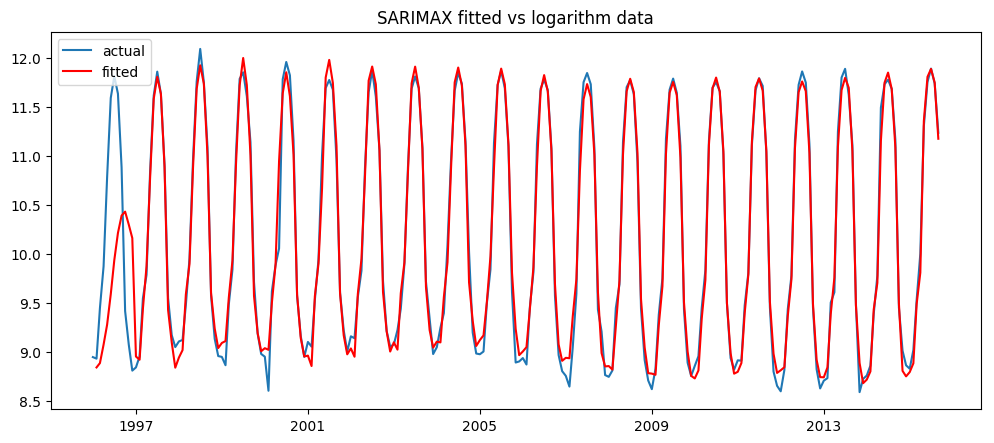

In [148]:
def train_SARIMAX(df, order, seasonal_order):
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    df_log = log_df(df)
    index_p85 = int(len(df_log.index) * 0.85)
    train = df_log[:index_p85]
    test = df_log[index_p85:]
    model = SARIMAX(train, trend='n', order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=-1)
    print model_fit.summary()
    plt.figure(figsize=(12, 5), dpi=100)
    plt.plot(train, label='actual')
    plt.plot(model_fit.fittedvalues[1:], color='red', label='fitted')
    plt.title("SARIMAX fitted vs logarithm data")
    plt.legend(loc="upper left")
    return model_fit

model_fit = train_SARIMAX(df_alaska, (1, 0, 1), (1,0,1,12))

<class 'pandas.core.series.Series'>


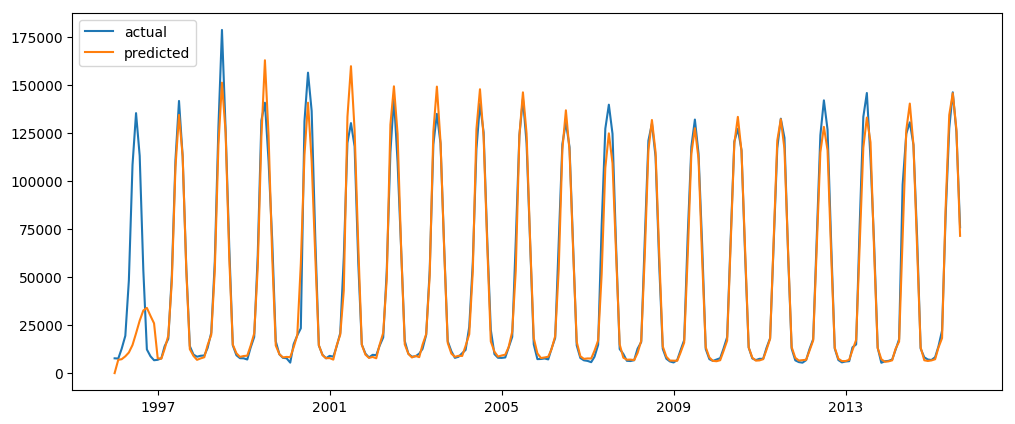

In [75]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = df_log
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff, fill_value=0)

ARIMA_log_predicted = pd.Series(model_fit.fittedvalues, copy=True)
ARIMA_predicted = np.exp(ARIMA_log_predicted)
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(data_alaska[:index_p85], label='actual')
plt.plot(ARIMA_predicted, label='predicted')
plt.legend(loc="upper left")

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1960: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


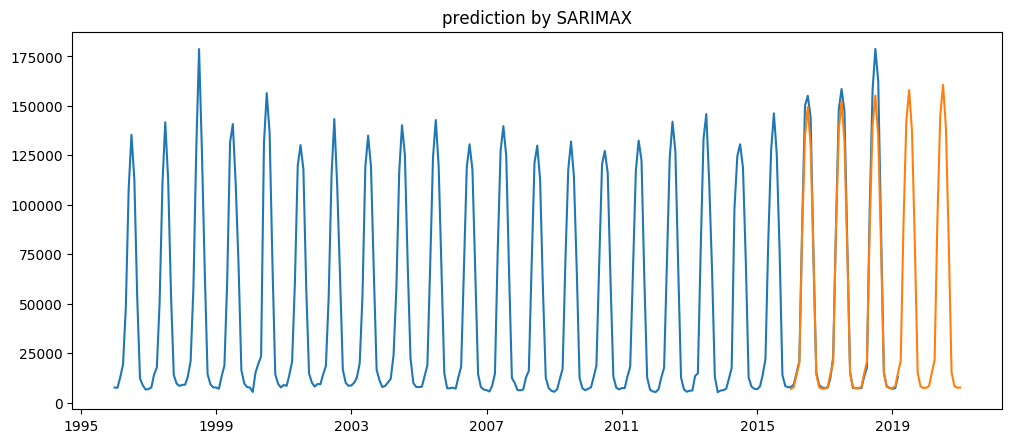

In [160]:
def SARIMAX_predict(model, df, start=240, end=300):
    data = agg_monthly_value(df)
    #df_log = log_df(df)
    forecast_log = model.predict(start=start, end=end, dynamic=True)
    forecast = np.exp(forecast_log)
    plt.figure(figsize=(12, 5), dpi=100)
    
    plt.plot(data)
    plt.plot(forecast)
    plt.title("prediction by SARIMAX")
SARIMAX_predict(model_fit, df_alaska)

deep dive cross border values of Texas


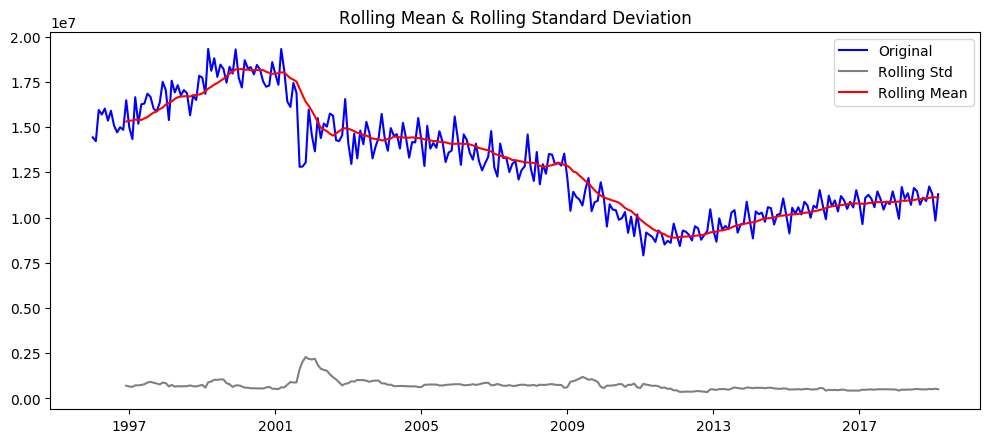

In [119]:
print "deep dive cross border values of Texas"
df_texas = df[(df['State'] == 'Texas')]
plot_rolling_mean_std(df_texas)

In [120]:
adfuller_test(df_texas)

Use Augmented Dickey-Fuller Test to see if time seies is stationary
ADF Statistic: -191.732437
p-value: 0.000000


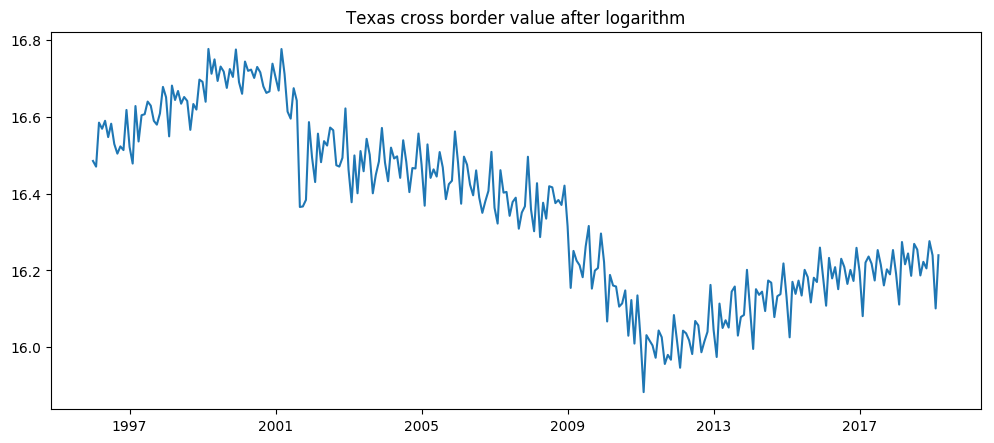

In [130]:
df_log_texas = log_df(df_texas)
plt.figure(figsize=(12, 5), dpi=100)
plt.title('Texas cross border value after logarithm')
plt.plot(df_log_texas)

Use autocorrelation and partial autocorrelation for determining order of AR and MA model


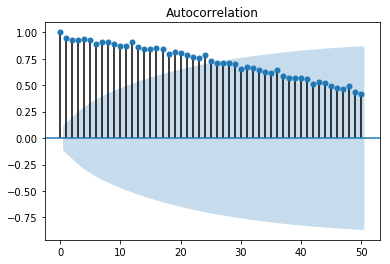

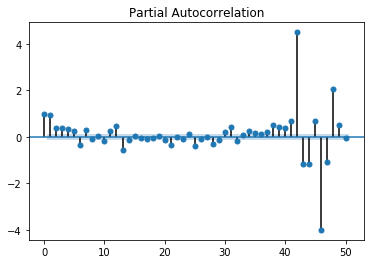

In [131]:
plot_acf_pacf(df_texas)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Value   No. Observations:                  237
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 430.294
Date:                            Tue, 03 Dec 2019   AIC                           -850.588
Time:                                    18:38:43   BIC                           -833.248
Sample:                                01-01-1996   HQIC                          -843.599
                                     - 09-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   5044.554      0.000       0.999       1.000
ma.L1         -0.2911      0.027   

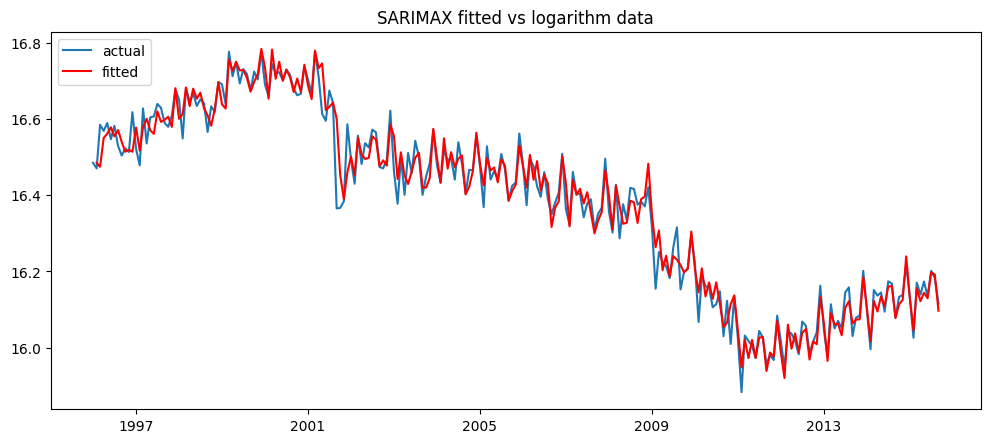

In [169]:
model_texas = train_SARIMAX(df_texas, (1, 0, 1), (1,0,1,12))

prediction by SARIMAX on Texas border cross entry value


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1960: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


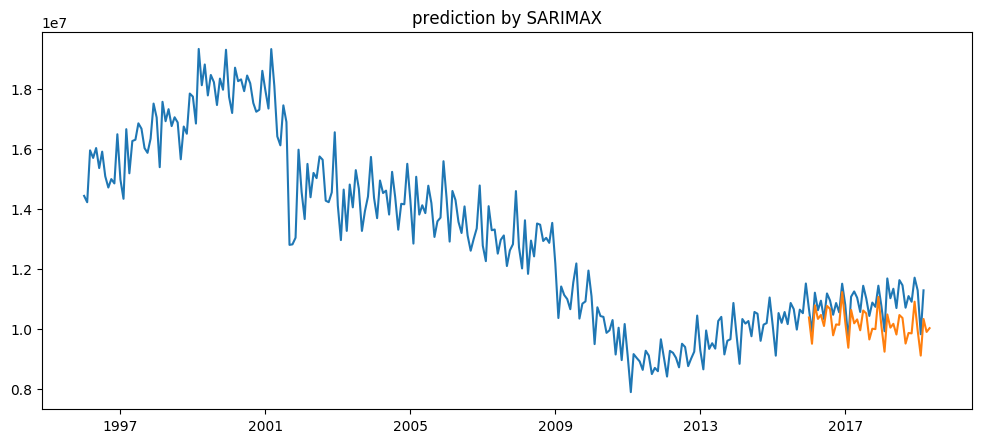

In [171]:
print "prediction by SARIMAX on Texas border cross entry value"
SARIMAX_predict(model_texas, df_texas, start=240, end=280)